In [1]:
import warnings
warnings.filterwarnings("ignore")


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import duckdb


# EDA

## About Data


This dataset provides information on motor vehicle operators (drivers) involved in traffic collisions occurring on county and local roadways. The dataset reports details of all traffic collisions occurring on county and local roadways within Montgomery County, as collected via the Automated Crash Reporting System (ACRS) of the Maryland State Police, and reported by the Montgomery County Police, Gaithersburg Police, Rockville Police, or the Maryland-National Capital Park Police. This dataset shows each collision data recorded and the drivers involved.



## Data Overview

In [2]:
DB_PATH = "data/data.duckdb"

conn = duckdb.connect(database=DB_PATH, read_only=False)

In [3]:
conn.sql("SHOW TABLES;")

┌──────────────┐
│     name     │
│   varchar    │
├──────────────┤
│ drivers      │
│ incidents    │
│ non_motorist │
└──────────────┘

In [4]:
conn.sql("SELECT * FROM drivers LIMIT 3;").fetchdf()

,report_number,local_case_number,agency_name,acrs_report_type,crash_datetime,route_type,road_name,cross-street_name,off-road_description,municipality,...,speed_limit,driverless_vehicle,parked_vehicle,vehicle_year,vehicle_make,vehicle_model,latitude,longitude,location,vehicle_type_group
0,DM8479000T,210020119.0,Takoma Park Police Depart,Property Damage Crash,2021-05-27 19:40:00,None,None,None,IN PARKING LOT,None,...,0,No,True,2017,HINO,TWK,38.987657,-76.987545,"(38.98765667, -76.987545)",None
1,MCP2970000R,15045937.0,MONTGOMERY,Property Damage Crash,2015-09-11 13:29:00,None,None,None,Parking Lot: \n2525 Ennalls Ave,None,...,5,No,False,2012,TOYOTA,SU,39.039917,-77.053649,"(39.03991652, -77.05364898)",Passenger Vehicles
2,MCP20160036,180040948.0,Montgomery County Police,Property Damage Crash,2018-08-17 14:25:00,None,None,None,PARKING LOT OF 16246 FREDERICK RD,None,...,15,No,False,2015,MAZD,TK,38.743373,-77.546997,"(38.743373, -77.54699707)",Passenger Vehicles


In [5]:
conn.sql("SELECT * FROM incidents LIMIT 3;").fetchdf()

,report_number,crash_datetime,hit,lane_direction,lane_type,number_of_lanes,direction,distance,road_grade,at_fault,first_harmful_event,second_harmful_event,junction,intersection_type,road_alignment,road_condition,road_division,distance_meters
0,MCP1123002M,2019-03-04 08:41:00,No,[West],None,2,EAST,200.0,GRADE DOWNHILL,DRIVER,OTHER VEHICLE,None,NON INTERSECTION,None,STRAIGHT,NO DEFECTS,"TWO-WAY, NOT DIVIDED",60.960
1,MCP21610009,2016-06-04 19:14:00,Yes,[East],None,1,EAST,500.0,LEVEL,DRIVER,PARKED VEHICLE,OTHER VEHICLE,NON INTERSECTION,None,STRAIGHT,NO DEFECTS,"TWO-WAY, NOT DIVIDED",152.400
2,MCP2790000P,2015-08-18 23:00:00,No,[South],None,2,SOUTH,30.0,LEVEL,UNKNOWN,PARKED VEHICLE,None,NON INTERSECTION,None,STRAIGHT,NO DEFECTS,"TWO-WAY, NOT DIVIDED",9.144


In [6]:
conn.sql("SELECT * FROM non_motorist LIMIT 3;").fetchdf()

,report_number,crash_date/time,person_id,pedestrian_type,pedestrian_movement,pedestrian_actions,pedestrian_location,at_fault,injury_severity,safety_equipment,pedestrian_category,is_helmet_present,is_lighting_present,is_reflective_wear
0,MCP9419004R,08/29/2023 02:00:00 PM,EEB1D2F0-0139-453B-8321-D30FC01D3FB7,OTHER,Other,OTHER,INSIDE BUILDING,No,POSSIBLE INJURY,NONE,OTHER,0.0,0.0,0.0
1,MCP3353001Z,11/30/2023 04:19:00 PM,2259BC33-1276-46BF-A263-15A1B7E079E5,PEDESTRIAN,Standing,NO IMPROPER ACTIONS,OTHER,No,POSSIBLE INJURY,None,PEDESTRIAN,NaN,NaN,NaN
2,MCP30750041,10/21/2023 10:34:00 PM,741BDE7D-D991-4C8D-9909-A400AD8C6B8C,OTHER,Other,OTHER,OTHER,Yes,SUSPECTED MINOR INJURY,None,OTHER,NaN,NaN,NaN


In [7]:
incidents_df = conn.sql("SELECT * FROM incidents;").fetchdf()
drivers_df = conn.sql("SELECT * FROM drivers").fetchdf()
nonmotorist_df = conn.sql("SELECT * FROM non_motorist").fetchdf()

In [8]:
incidents_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106601 entries, 0 to 106600
Data columns (total 18 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   report_number         106601 non-null  object 
 1   crash_datetime        106601 non-null  object 
 2   hit                   104906 non-null  object 
 3   lane_direction        93146 non-null   object 
 4   lane_type             17547 non-null   object 
 5   number_of_lanes       94261 non-null   object 
 6   direction             93158 non-null   object 
 7   distance              95021 non-null   float64
 8   road_grade            92530 non-null   object 
 9   at_fault              106601 non-null  object 
 10  first_harmful_event   105951 non-null  object 
 11  second_harmful_event  27871 non-null   object 
 12  junction              79122 non-null   object 
 13  intersection_type     50974 non-null   object 
 14  road_alignment        92748 non-null   object 
 15  

In [9]:
drivers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188090 entries, 0 to 188089
Data columns (total 40 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   report_number                  188090 non-null  object        
 1   local_case_number              188070 non-null  float64       
 2   agency_name                    188090 non-null  object        
 3   acrs_report_type               188090 non-null  object        
 4   crash_datetime                 188090 non-null  datetime64[ns]
 5   route_type                     169696 non-null  object        
 6   road_name                      168741 non-null  object        
 7   cross-street_name              162133 non-null  object        
 8   off-road_description           17356 non-null   object        
 9   municipality                   19126 non-null   object        
 10  related_non-motorist           6040 non-null    object        
 11  

In [10]:
nonmotorist_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6250 entries, 0 to 6249
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   report_number        6250 non-null   object 
 1   crash_date/time      6250 non-null   object 
 2   person_id            6250 non-null   object 
 3   pedestrian_type      6250 non-null   object 
 4   pedestrian_movement  6080 non-null   object 
 5   pedestrian_actions   5956 non-null   object 
 6   pedestrian_location  6097 non-null   object 
 7   at_fault             5963 non-null   object 
 8   injury_severity      6250 non-null   object 
 9   safety_equipment     3839 non-null   object 
 10  pedestrian_category  6250 non-null   object 
 11  is_helmet_present    3839 non-null   float64
 12  is_lighting_present  3839 non-null   float64
 13  is_reflective_wear   3839 non-null   float64
dtypes: float64(3), object(11)
memory usage: 683.7+ KB


### Missing Values

In [11]:
def plot_non_null_percentage(non_null_counts, total_rows, color='blue', title="Non null percentage"):
  
    # Calculate percentage of non-null values
    non_null_percentage = (non_null_counts / total_rows) * 100

    # Prepare data for plotting
    data = non_null_percentage.reset_index()
    data.columns = ['Column', 'Non-Null Percentage']

    # Plot
    plt.figure(figsize=(12, 6))
    barplot = sns.barplot(data=data, x='Column', y='Non-Null Percentage', color=color, alpha=0.6)

    # Annotate bars with percentages
    for bar, percentage in zip(barplot.patches, non_null_percentage):
        plt.text(
            bar.get_x() + bar.get_width() / 2,  # X-coordinate of the bar's center
            bar.get_height(),                 # Y-coordinate at the top of the bar
            f'{percentage:.1f}%',             # Text to display (formatted percentage)
            ha='center',                      # Horizontal alignment
            va='bottom',                      # Vertical alignment
            fontsize=10,                      # Font size
            color='black'                     # Font color
        )

    # Add labels and title
    plt.title(title, fontsize=16)
    plt.xlabel('Columns', fontsize=14)
    plt.ylabel('Non-Null Percentage (%)', fontsize=14)
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
    plt.ylim(0, 105)  # Set a slightly higher Y-axis limit for better visibility of annotations
    plt.tight_layout()
    plt.show()


In [12]:
incidents_nonnull_counts = incidents_df.count()
drivers_nonnull_counts = drivers_df.count()
nonmotorist_nonnull_counts = nonmotorist_df.count()


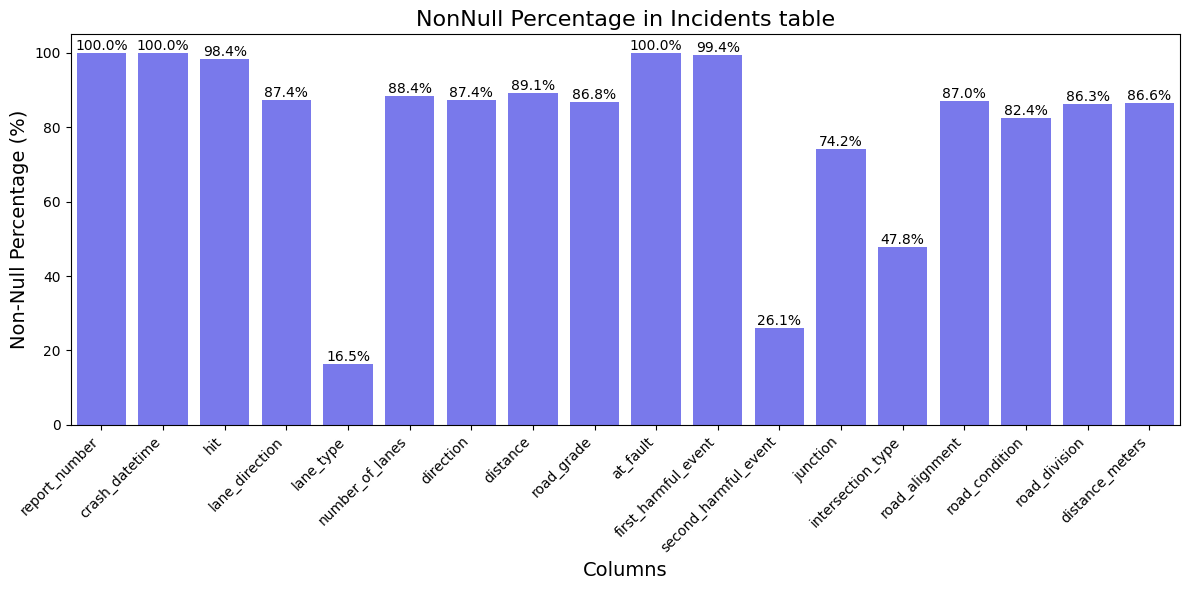

In [13]:
plot_non_null_percentage(incidents_nonnull_counts, len(incidents_df), title="NonNull Percentage in Incidents table")

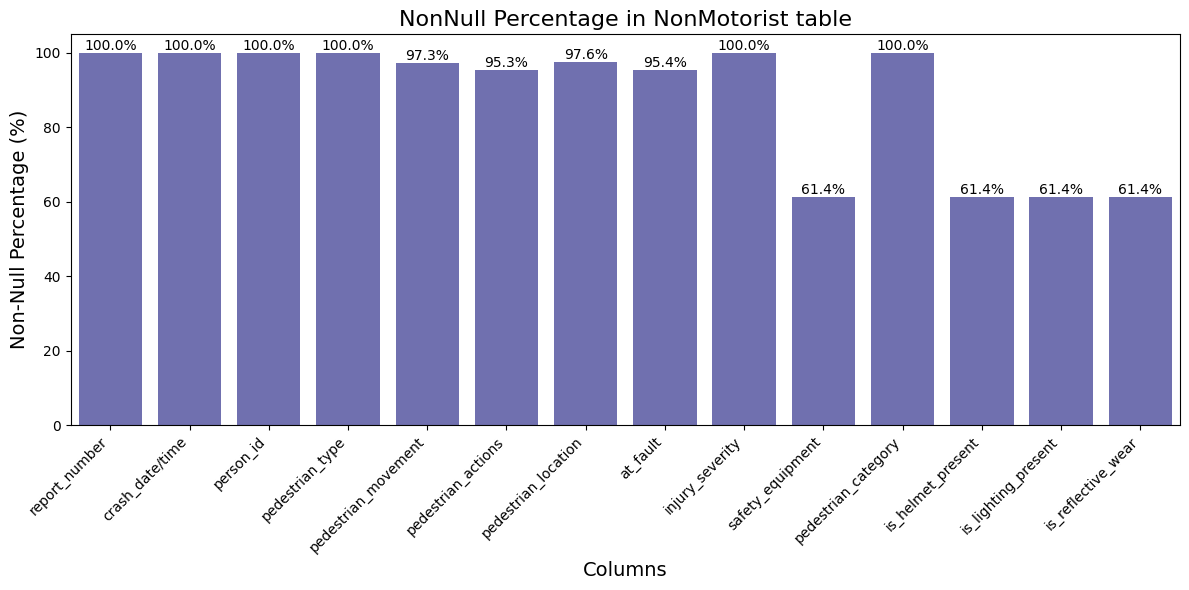

In [14]:
plot_non_null_percentage(nonmotorist_nonnull_counts, len(nonmotorist_df),
                         color="darkblue", title="NonNull Percentage in NonMotorist table")

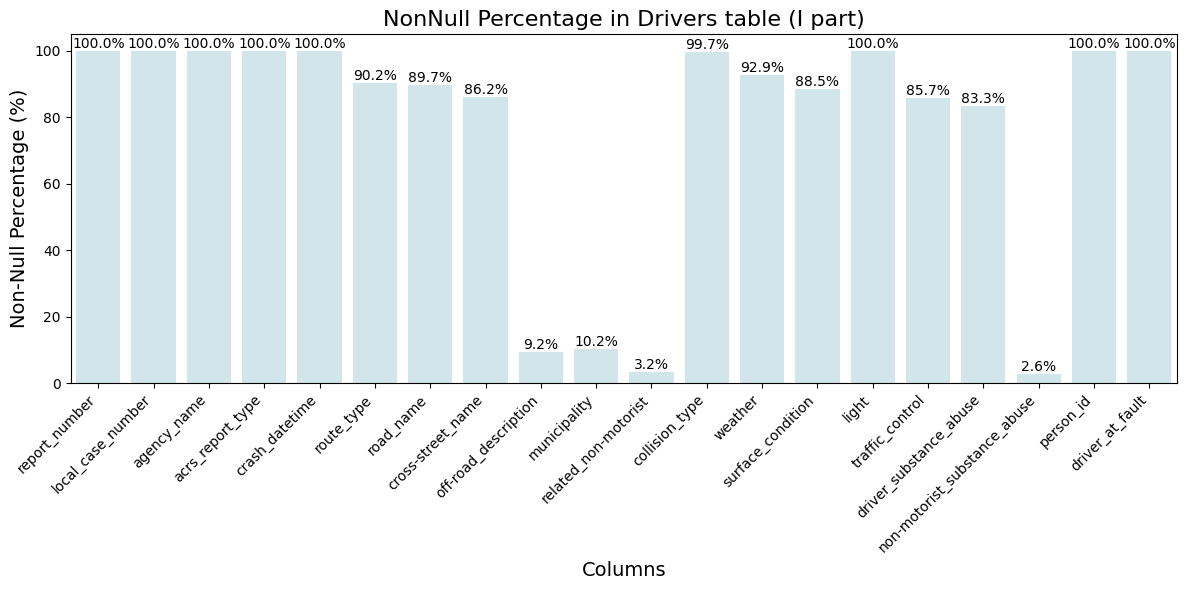

In [15]:
drivers_nonnull_counts_1st = drivers_nonnull_counts[:20]
drivers_nonnull_counts_2nd = drivers_nonnull_counts[20:]


plot_non_null_percentage(drivers_nonnull_counts_1st, len(drivers_df), color="lightblue", title="NonNull Percentage in Drivers table (I part)")

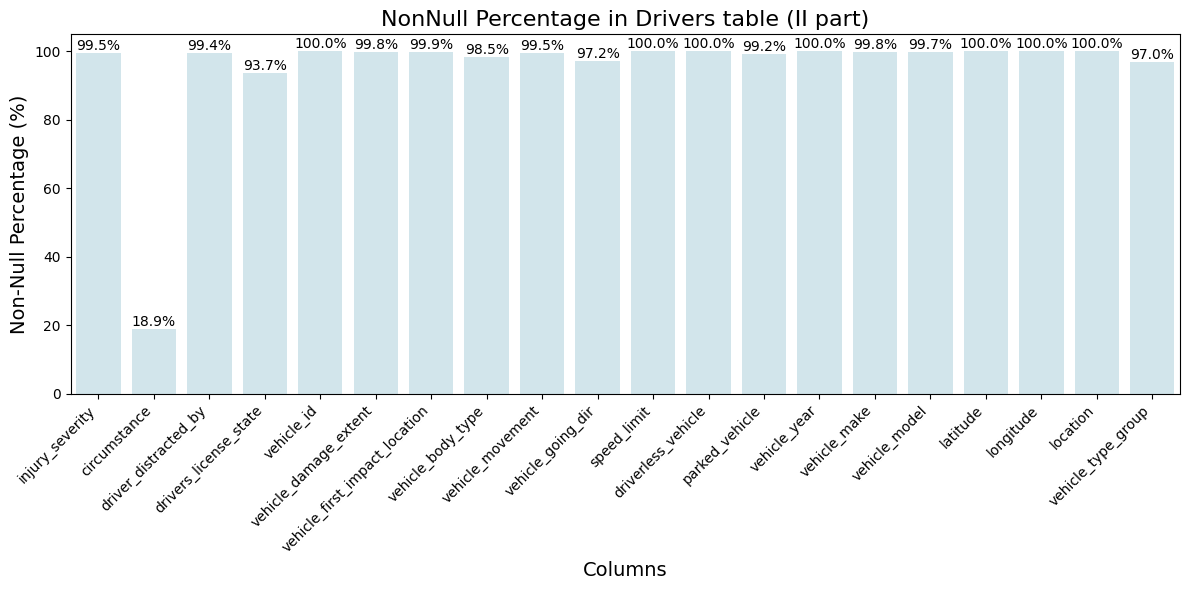

In [16]:
plot_non_null_percentage(drivers_nonnull_counts_2nd, len(drivers_df), color="lightblue", title="NonNull Percentage in Drivers table (II part)")

### Time-Series Analysis: Number of Collisions

In [44]:
collision_grouped_by_month = conn.sql("""
    SELECT 
        strftime(CAST(crash_datetime AS TIMESTAMP), '%Y') AS year,
        strftime(CAST(crash_datetime AS TIMESTAMP), '%m') AS month,
        COUNT(*) AS number_of_collisions
    FROM incidents
    WHERE CAST(crash_datetime AS TIMESTAMP) <= TIMESTAMP '2024-10-01'
    GROUP BY year, month
    ORDER BY year, month;
""").fetchdf()


collision_grouped_by_month["date"] = pd.to_datetime(collision_grouped_by_month['year'].astype(str) + '-' + collision_grouped_by_month['month'])
collision_grouped_by_month['quarter'] = collision_grouped_by_month['date'].dt.to_period('Q').astype(str)
collision_grouped_by_quarter = collision_grouped_by_month.groupby('quarter', as_index=False)['number_of_collisions'].sum()
collision_grouped_by_year = collision_grouped_by_month.groupby('year', as_index=False)['number_of_collisions'].sum()

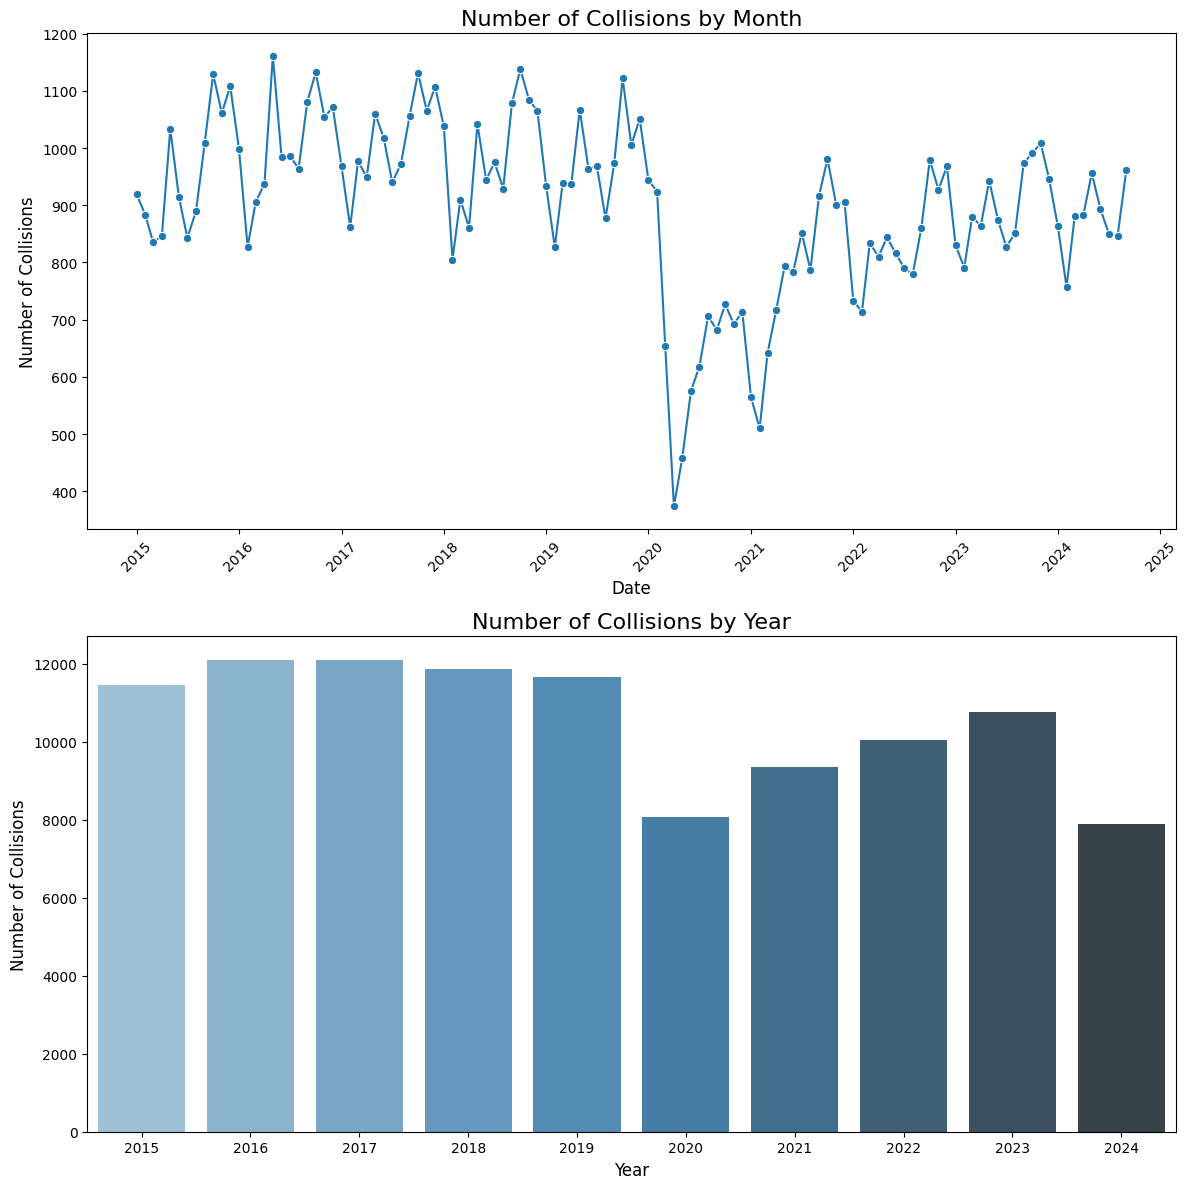

In [45]:
# Create the figure and axes for two stacked plots
fig, axes = plt.subplots(2, 1, figsize=(12, 12), sharex=False)

# Plot collisions by month
sns.lineplot(data=collision_grouped_by_month, x='date', y='number_of_collisions', marker='o', ax=axes[0])
axes[0].set_title('Number of Collisions by Month', fontsize=16)
axes[0].set_xlabel('Date', fontsize=12)
axes[0].set_ylabel('Number of Collisions', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)  # Rotate x-axis for better readability

# Plot collisions by year
sns.barplot(data=collision_grouped_by_year, x='year', y='number_of_collisions', palette='Blues_d', ax=axes[1])
axes[1].set_title('Number of Collisions by Year', fontsize=16)
axes[1].set_xlabel('Year', fontsize=12)
axes[1].set_ylabel('Number of Collisions', fontsize=12)

# Adjust layout
plt.tight_layout()
plt.show()
